##  OCT Segmentation Results
Visualize results generated by the train_oct.py script.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import h5py
from functools import partial

import sys, time
import numpy as np
import pylab as plt
from scipy.io import loadmat


sys.path.append('../..')
import cnn_tools as ct
import train_oct

Using Theano backend.


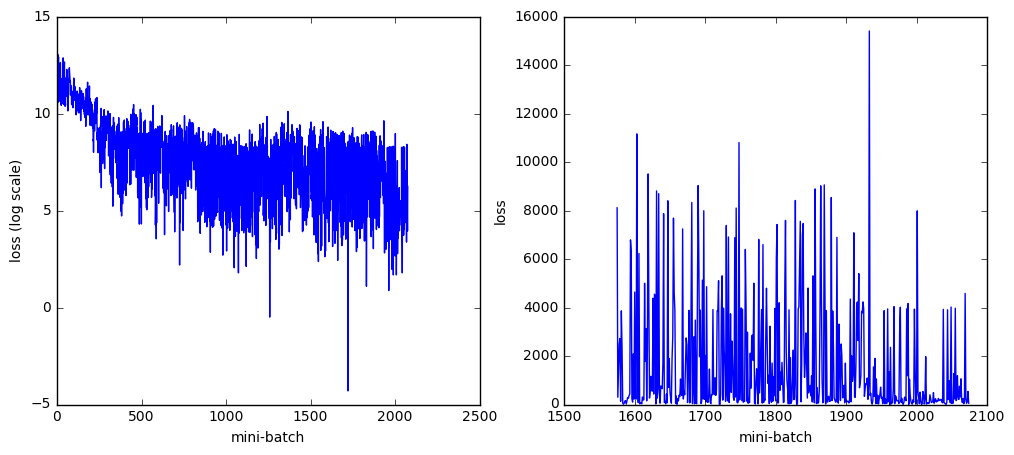

In [2]:
# Look at how training evolved
fn = 'oct_seg_fold0_valid_epoch0082.npz'

if os.path.exists(fn):
    f = np.load(fn)
    loss = f['s']
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(np.log(loss))
    plt.ylabel('loss (log scale)')
    plt.xlabel('mini-batch')
        
    plt.subplot(1,2,2)
    plt.plot(np.arange(len(loss)-500, len(loss)), loss[-500:])
    plt.xlabel('mini-batch')
    plt.ylabel('loss')

else:
    print('weight file %s not found' % fn)
    

In [4]:
# For now, just load results that were pre-computed on the cluster.
# My laptop is struggling to even deploy this stuff.

#f = np.load('oct_seg_50_50_fold0_deploy_final.npz')
f = np.load('oct_seg_fold0_deploy_final.npz')
#f = np.load('oct_seg_40_60_fold0_deploy_final.npz')

X = f['X']
Y = f['Y']
Y_hat = f['Y_hat']
test_slices = f['test_slices']
valid_slices = f['valid_slices']

train_slices = [x for x in range(50) if x not in test_slices]

print(X.shape)
print(test_slices)


(50, 1, 512, 748)
[ 0  5 10 15 20 25 30 35 40 45]


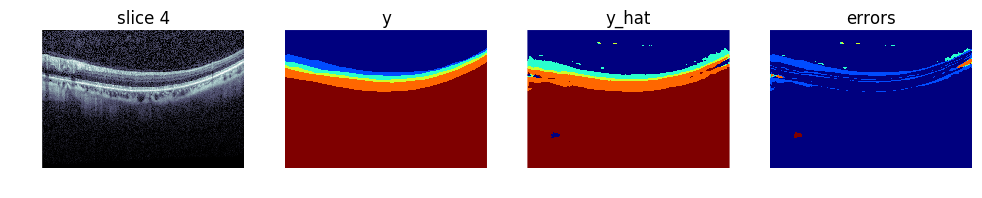

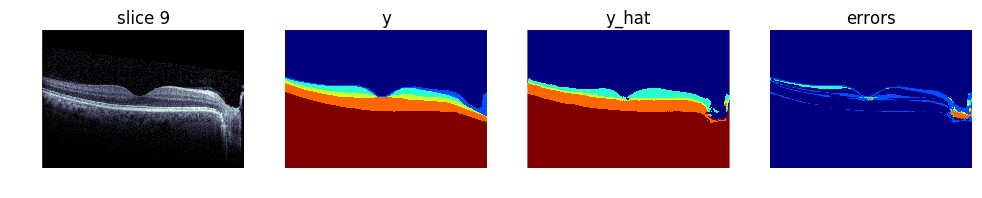

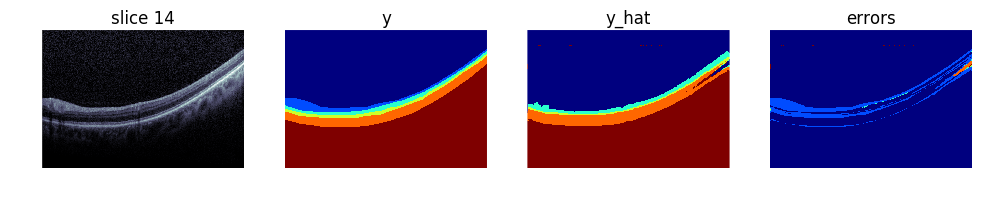

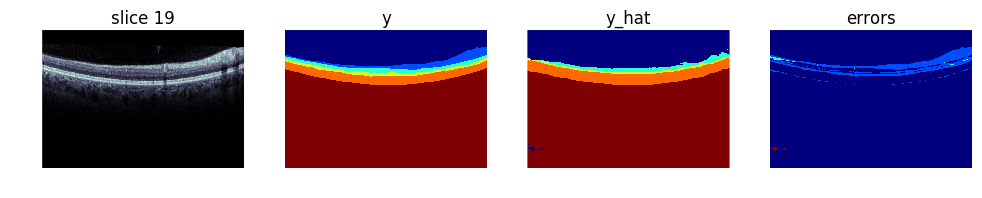

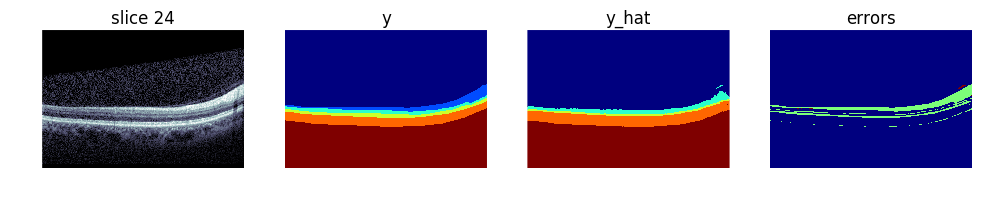

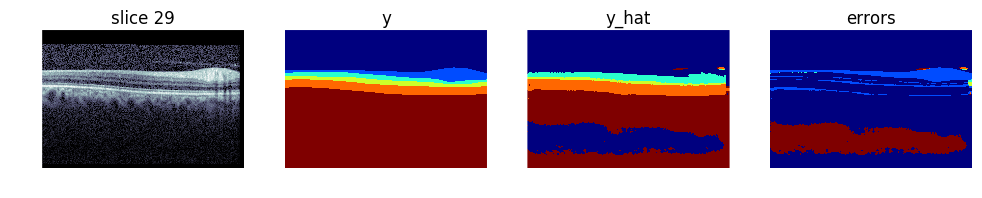

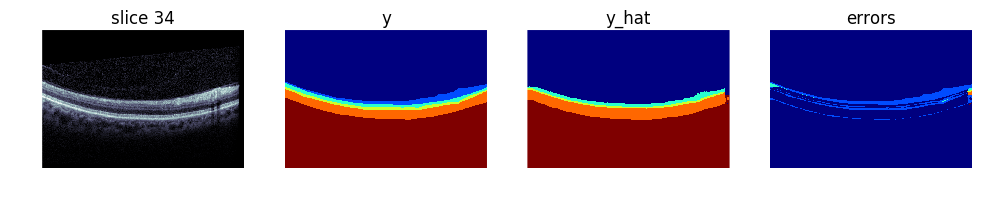

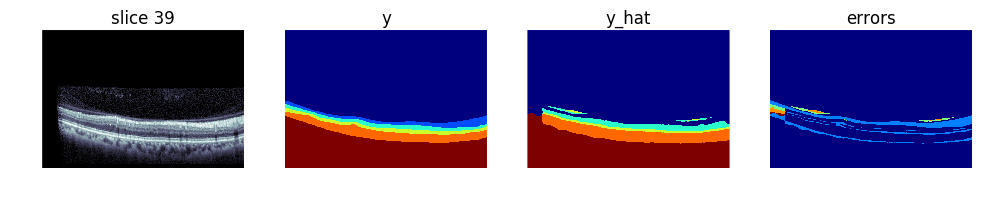

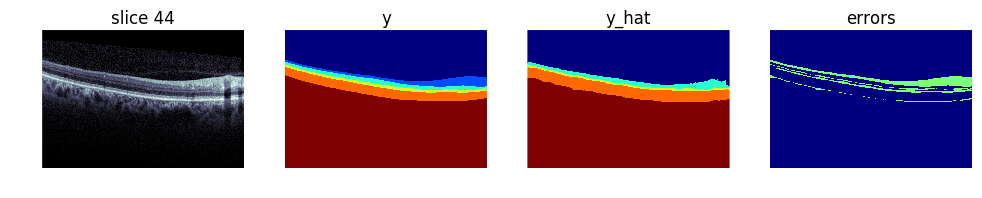

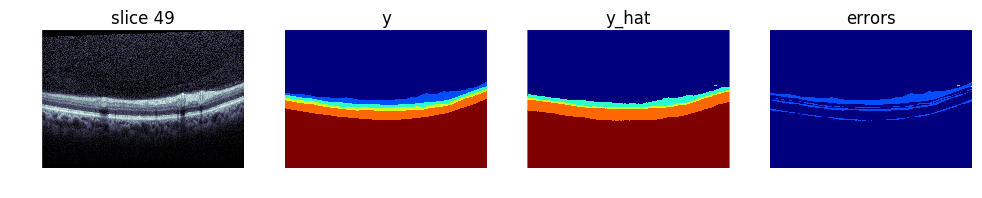

In [5]:
slices_to_view = valid_slices[:10]

for ts in slices_to_view:
    xi = np.squeeze(X[ts,...])
    yi = np.squeeze(Y[ts,...])
    yi_hat = Y_hat[ts,...]
    
    plt.figure(figsize=(12,3))
    plt.subplot(1,4,1)
    plt.imshow(xi, interpolation='none', cmap='bone')
    plt.axis('off')
    plt.title('slice %d' % ts)
    
    plt.subplot(1,4,2)
    #plt.imshow(xi, interpolation='none', cmap='bone')
    plt.imshow(yi, interpolation='none', cmap='jet')
    plt.axis('off')
    plt.title('y')
    
    plt.subplot(1,4,3)
    plt.imshow(yi_hat, interpolation='none')
    plt.axis('off')
    plt.title('y_hat')
    
    plt.subplot(1,4,4)
    plt.imshow(np.abs(yi - yi_hat), interpolation='none')
    plt.axis('off')
    plt.title('errors')
    
    

(50, 1, 512, 748)
(50, 1, 512, 748)


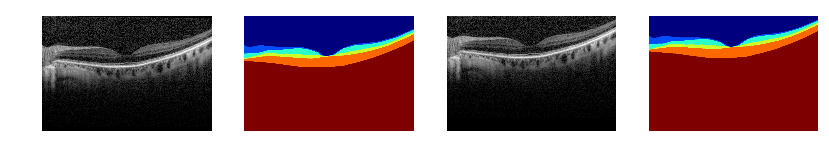

In [54]:
print(X.shape)
print(Y.shape)

X_dy, Y_dy = train_oct.tian_shift_updown(X, Y)

idx = 0
plt.figure(figsize=(10,13))
plt.subplot(1,4,1)
plt.imshow(X[idx,0,...], interpolation=None, cmap='gray')
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(Y[idx,0,...], interpolation=None, cmap='jet')
plt.axis('off')

plt.subplot(1,4,3)
plt.imshow(X_dy[idx,0,...], interpolation=None, cmap='gray'); plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(Y_dy[idx,0,...], interpolation=None, cmap='jet'); plt.axis('off')

plt.show()